In [21]:
import pandas as pd
import numpy as np
from pathlib import Path

class SubjectiveDataOrganizer:
    def __init__(self, data_path):
        self.data_path = Path(data_path)
        
    def load_game_performance(self):
        """Load game performance (long format)"""
        df = pd.read_csv(self.data_path / 'game-performance/game-performance.csv')
        
        df['date'] = pd.to_datetime(df['timestamp'], dayfirst=True)
        return df
    
    def load_wide_format(self, category, filename):
        """Load wide format files (daily_load, wellness metrics)"""
        df = pd.read_csv(self.data_path / f'{category}/{filename}')
        
        # Melt from wide to long format
        id_col = df.columns[0]  # First column (Date/Readiness/etc)
        df_long = df.melt(
            id_vars=[id_col], 
            var_name='team_player_id',
            value_name=filename.replace('.csv', '')
        )
        
        df_long['date'] = pd.to_datetime(df_long[id_col], dayfirst=True)
        return df_long.drop(columns=[id_col])
    
    def organize_by_player(self):
        """Organize all data by player_id"""
        
        # Load game performance
        print("Loading game performance...")
        game_perf = self.load_game_performance()
        
        # Load training load metrics
        print("Loading training load metrics...")
        training_metrics = [
            'acwr.csv', 'atl.csv', 'ctl28.csv', 'ctl42.csv',
            'daily_load.csv', 'monotony.csv', 'strain.csv', 'weekly_load.csv'
        ]
        
        training_data = []
        for metric in training_metrics:
            try:
                df = self.load_wide_format('training-load', metric)
                training_data.append(df)
                print(f"  Loaded {metric}")
            except Exception as e:
                print(f"  Error loading {metric}: {e}")
        
        # Merge all training data
        if training_data:
            training_df = training_data[0]
            for df in training_data[1:]:
                training_df = training_df.merge(
                    df, on=['date', 'team_player_id'], how='outer'
                )
        else:
            training_df = pd.DataFrame()
        
        # Load wellness metrics
        print("Loading wellness metrics...")
        wellness_metrics = [
            'fatigue.csv', 'mood.csv', 'readiness.csv',
            'sleep_duration.csv', 'sleep_quality.csv',
            'soreness.csv', 'stress.csv'
        ]
        
        wellness_data = []
        for metric in wellness_metrics:
            try:
                df = self.load_wide_format('wellness', metric)
                wellness_data.append(df)
                print(f"  Loaded {metric}")
            except Exception as e:
                print(f"  Error loading {metric}: {e}")
        
        # Merge wellness data
        if wellness_data:
            wellness_df = wellness_data[0]
            for df in wellness_data[1:]:
                wellness_df = wellness_df.merge(
                    df, on=['date', 'team_player_id'], how='outer'
                )
        else:
            wellness_df = pd.DataFrame()
        
        # Load illness and injury
        print("Loading illness and injury data...")
        try:
            illness_df = pd.read_csv(self.data_path / 'illness/illness.csv')
            print(f"  Loaded illness data: {illness_df.shape}")
        except Exception as e:
            print(f"  Error loading illness: {e}")
            illness_df = pd.DataFrame()
            
        try:
            injury_df = pd.read_csv(self.data_path / 'injury/injury.csv')
            print(f"  Loaded injury data: {injury_df.shape}")
        except Exception as e:
            print(f"  Error loading injury: {e}")
            injury_df = pd.DataFrame()
        
        # Combine all data
        print("Merging all datasets...")
        final_df = game_perf.copy()
        
        if not training_df.empty:
            final_df = final_df.merge(
                training_df, 
                left_on=['player_name', 'date'],
                right_on=['team_player_id', 'date'],
                how='outer'
            )
        
        if not wellness_df.empty:
            if 'team_player_id' in final_df.columns:
                final_df = final_df.merge(
                    wellness_df,
                    on=['team_player_id', 'date'],
                    how='outer'
                )
            else:
                final_df = final_df.merge(
                    wellness_df,
                    left_on=['player_name', 'date'],
                    right_on=['team_player_id', 'date'],
                    how='outer'
                )
        
        # Add player_id and team_id columns
        if 'team_player_id' not in final_df.columns and 'player_name' in final_df.columns:
            final_df['team_player_id'] = final_df['player_name']
        
        final_df['player_id'] = final_df['team_player_id']
        final_df['team_id'] = final_df['team_player_id'].str.split('-').str[0]
        
        print(f"Final dataset shape: {final_df.shape}")
        return final_df
    
    def organize_by_team(self):
        """Organize data aggregated by team"""
        print("\nOrganizing by team...")
        player_df = self.organize_by_player()
        
        # Get numeric columns for aggregation
        numeric_cols = player_df.select_dtypes(include=[np.number]).columns.tolist()
        
        # Remove date-related numeric columns if any
        agg_cols = [col for col in numeric_cols if col not in ['team_perf', 'offensive_value', 'defensive_value']]
        
        if not agg_cols:
            print("No numeric columns to aggregate")
            return player_df
        
        # Create aggregation dictionary
        agg_dict = {col: 'mean' for col in agg_cols}
        agg_dict['player_id'] = 'count'  # Count number of players
        
        # Aggregate by team and date
        team_df = player_df.groupby(['team_id', 'date']).agg(agg_dict).reset_index()
        team_df.rename(columns={'player_id': 'num_players'}, inplace=True)
        
        print(f"Team aggregated dataset shape: {team_df.shape}")
        return team_df
    
    def export_organized_data(self, output_path, format='csv'):
        """Export organized data"""
        output_path = Path(output_path)
        output_path.mkdir(parents=True, exist_ok=True)
        
        print("\n=== Exporting Player-Level Data ===")
        player_df = self.organize_by_player()
        
        print("\n=== Exporting Team-Level Data ===")
        team_df = self.organize_by_team()
        
        if format == 'csv':
            player_file = output_path / 'player_organized.csv'
            team_file = output_path / 'team_organized.csv'
            
            player_df.to_csv(player_file, index=False)
            team_df.to_csv(team_file, index=False)
            
            print(f"\nExported to:")
            print(f"  {player_file}")
            print(f"  {team_file}")
            
        elif format == 'parquet':
            player_file = output_path / 'player_organized.parquet'
            team_file = output_path / 'team_organized.parquet'
            
            player_df.to_parquet(player_file)
            team_df.to_parquet(team_file)
            
            print(f"\nExported to:")
            print(f"  {player_file}")
            print(f"  {team_file}")
        
        return player_df, team_df

# Usage
organizer = SubjectiveDataOrganizer('/kaggle/input/soccermon/subjective')
player_df, team_df = organizer.export_organized_data('/kaggle/working', format='csv')

# Display summary
print("\n=== SUMMARY ===")
print(f"\nPlayer-level data:")
print(f"  Shape: {player_df.shape}")
print(f"  Columns: {list(player_df.columns)}")
print(f"\nFirst few rows:")
print(player_df.head())

print(f"\nTeam-level data:")
print(f"  Shape: {team_df.shape}")
print(f"  Columns: {list(team_df.columns)}")
print(f"\nFirst few rows:")
print(team_df.head())

# Check for missing values
print(f"\n=== Missing Values (Player Data) ===")
print(player_df.isnull().sum()[player_df.isnull().sum() > 0])

print(f"\n=== Date Range ===")
print(f"Start: {player_df['date'].min()}")
print(f"End: {player_df['date'].max()}")
print(f"Unique dates: {player_df['date'].nunique()}")


=== Exporting Player-Level Data ===
Loading game performance...
Loading training load metrics...
  Loaded acwr.csv
  Loaded atl.csv
  Loaded ctl28.csv
  Loaded ctl42.csv
  Loaded daily_load.csv
  Loaded monotony.csv
  Loaded strain.csv
  Loaded weekly_load.csv
Loading wellness metrics...
  Loaded fatigue.csv
  Loaded mood.csv
  Loaded readiness.csv
  Loaded sleep_duration.csv
  Loaded sleep_quality.csv
  Loaded soreness.csv
  Loaded stress.csv
Loading illness and injury data...
  Loaded illness data: (15, 3)
  Loaded injury data: (162, 3)
Merging all datasets...
Final dataset shape: (36551, 24)

=== Exporting Team-Level Data ===

Organizing by team...
Loading game performance...
Loading training load metrics...
  Loaded acwr.csv
  Loaded atl.csv
  Loaded ctl28.csv
  Loaded ctl42.csv
  Loaded daily_load.csv
  Loaded monotony.csv
  Loaded strain.csv
  Loaded weekly_load.csv
Loading wellness metrics...
  Loaded fatigue.csv
  Loaded mood.csv
  Loaded readiness.csv
  Loaded sleep_duration.

In [29]:
def clean_ids(df):
    """
    Fills missing player_names using team_player_id 
    and ensures we have a consistent ID column.
    """
    # Coalesce: If team_player_id is null, use player_name, and vice versa
    df['team_player_id'] = df['team_player_id'].fillna(df['player_name'])
    
    # In this dataset, it looks like 'player_name' IS the ID (e.g., TeamA-036...)
    # So we simply fill the missing names with the ID
    df['player_name'] = df['player_name'].fillna(df['team_player_id'])
    
    # Extract clean Team ID (everything before the first hyphen)
    df['team_id'] = df['team_player_id'].astype(str).str.split('-').str[0]
    
    return df

# 1. Clean the Player Data
print("Cleaning Player IDs...")
player_df = clean_ids(player_df)

# 2. Add a 'is_game_day' flag (Helpful for analysis later)
player_df['is_game_day'] = player_df['team_performance'].notnull().astype(int)

# 3. Save the CLEAN versions
print("Saving clean versions...")
player_df.to_csv('/kaggle/working/player_organized_clean.csv', index=False)

# Check the missing values again
print("\n=== Updated Missing Values (Should be 0 for player_name) ===")
print(player_df[['player_name', 'team_player_id', 'team_id']].isnull().sum())
print("\nFirst row example:")
print(player_df[['date', 'player_name', 'daily_load', 'team_performance']].head(1))

Cleaning Player IDs...
Saving clean versions...

=== Updated Missing Values (Should be 0 for player_name) ===
player_name       0
team_player_id    0
team_id           0
dtype: int64

First row example:
        date                                 player_name  daily_load  \
0 2020-01-01  TeamA-0362cdd5-7a63-480a-a46a-62a99fb1692f         0.0   

   team_performance  
0               NaN  


In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Load the clean data
df = pd.read_csv('/kaggle/working/player_organized_clean.csv')

# 2. Select the "State" Features
# These define the athlete's condition at any moment
features = [
    'daily_load', 'acwr', 'atl', 'ctl28',  # Load
    'fatigue', 'mood', 'readiness', 'soreness', 'sleep_quality' # Wellness
]

# 3. Handle Missing Values (Forward Fill per player)
# We use ffill because yesterday's fatigue is the best guess for today's if missing
print("Imputing missing values...")
df[features] = df.groupby('player_name')[features].transform(lambda x: x.ffill().bfill().fillna(0))

# 4. Normalize (0 to 1 scaling)
print("Normalizing features...")
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Replace original columns with scaled versions for training
df_scaled = df.copy()
df_scaled[features] = scaled_data

print("Data ready for TF-SOM.")
print(f"Feature vector size: {len(features)}")

Imputing missing values...
Normalizing features...
Data ready for TF-SOM.
Feature vector size: 9


In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('/kaggle/working/player_organized_clean.csv')
df['date'] = pd.to_datetime(df['date'])

# 2. Pick the Player with the most data (Best candidate for TF-SOM)
player_counts = df.groupby('player_name').size()
best_player_id = player_counts.idxmax()
print(f"Selected Player for Analysis: {best_player_id}")

# 3. Filter and Sort
player_df = df[df['player_name'] == best_player_id].sort_values('date').copy()

# 4. Select Variables (Inputs for the Map)
# We mix Load (Input) and Wellness (State) to see the full picture
features = [
    'daily_load', 'acwr', 'monotony', 'strain',  # Inputs (Training)
    'fatigue', 'mood', 'sleep_quality', 'soreness' # Internal State
]

# 5. Advanced Interpolation (Time-based)
# This respects the actual time gaps better than simple ffill
player_df = player_df.set_index('date')
player_df[features] = player_df[features].interpolate(method='time')
# Fill remaining edges (start/end)
player_df[features] = player_df[features].ffill().bfill()
player_df = player_df.reset_index()

# 6. Normalize (0-1)
scaler = MinMaxScaler()
data_matrix = scaler.fit_transform(player_df[features])

print(f"Data Shape: {data_matrix.shape}")
print("Missing values remaining:", np.isnan(data_matrix).sum())

Selected Player for Analysis: TeamB-6d568bee-175f-4dcb-9d3a-0f3e8f35de07
Data Shape: (732, 8)
Missing values remaining: 0


Training with High Variance parameters...
Training on 732 time steps for 500 epochs...
Training Done.


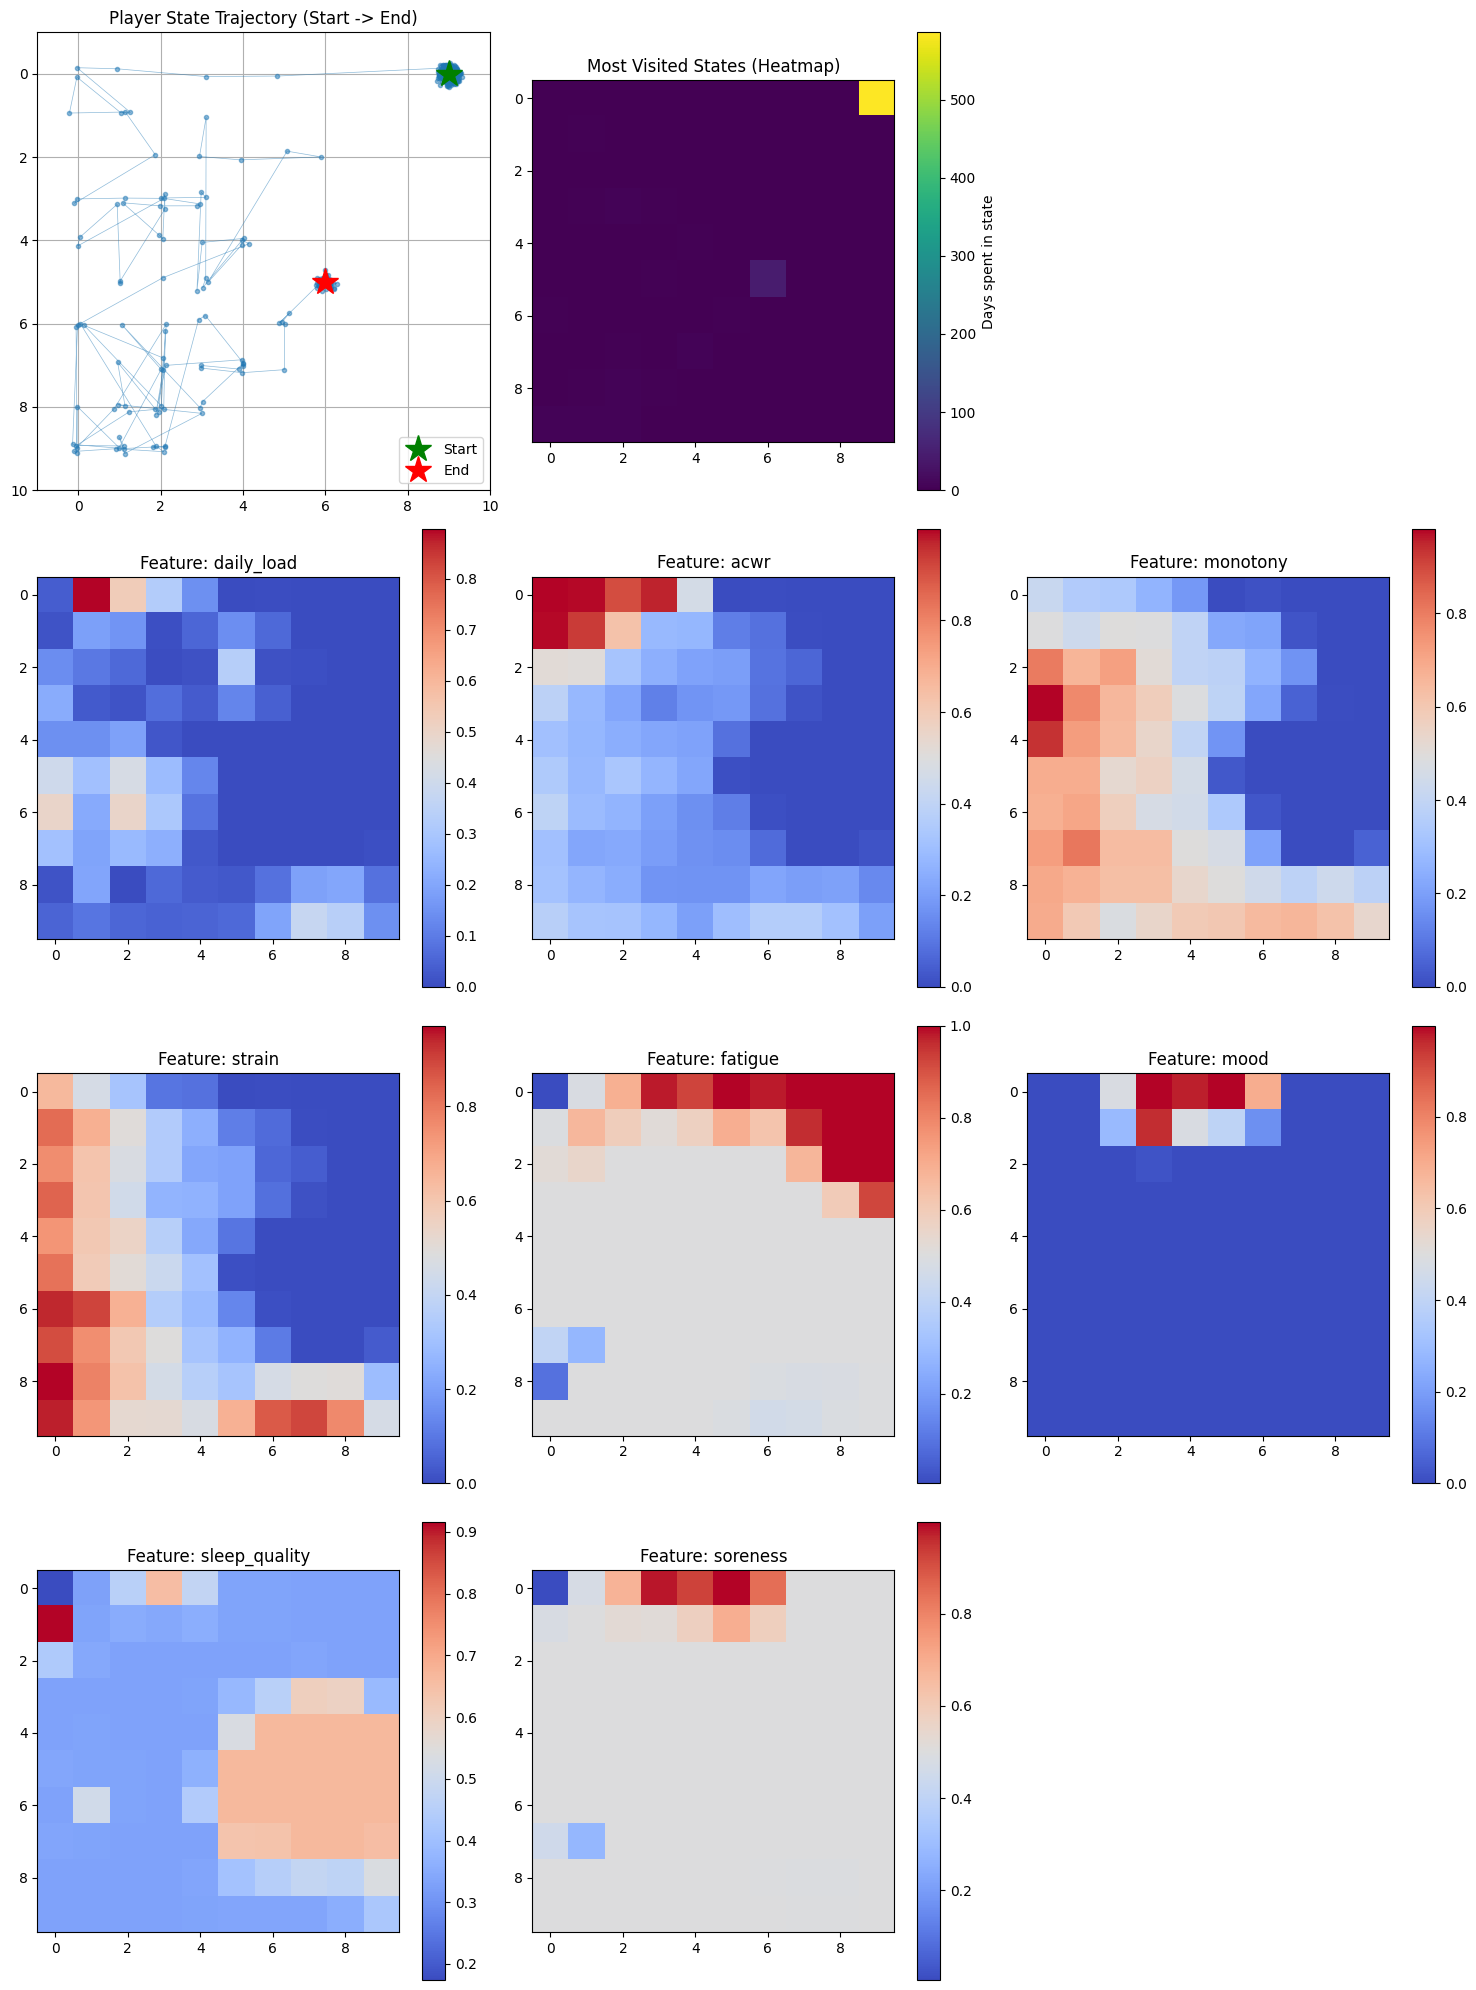


=== DEBUG: Data Variance ===
       daily_load        acwr    monotony      strain     fatigue        mood  \
count  732.000000  732.000000  732.000000  732.000000  732.000000  732.000000   
mean     0.019045    0.042356    0.079515    0.073856    0.899590    0.004098   
std      0.080196    0.132465    0.207447    0.205992    0.207156    0.063931   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    1.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    1.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    1.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

       sleep_quality    soreness  
count     732.000000  732.000000  
mean        0.357468    0.499317  
std         0.089892    0.041346  
min         0.000000    0.000000  
25%         0.333333    0.500000  
50%         0.333333    0.5000

In [33]:
class TFSOM:
    def __init__(self, x, y, input_dim, temporal_weight=0.3, sigma=1.0, lr=0.5):
        self.x = x
        self.y = y
        self.input_dim = input_dim
        self.temporal_weight = temporal_weight
        self.sigma = sigma
        self.lr = lr
        
        # Random initialization
        self.weights = np.random.random((x, y, input_dim))
        self.activation_map = np.zeros((x, y))
        
    def _get_coords(self, index):
        return np.array([index // self.y, index % self.y])

    def find_bmu_temporal(self, input_vec, prev_bmu_coords=None):
        # 1. Feature Distance (Euclidean)
        feature_dist = np.linalg.norm(self.weights - input_vec, axis=2)
        
        # 2. Temporal Distance (Grid proximity)
        if prev_bmu_coords is not None:
            xx, yy = np.meshgrid(np.arange(self.y), np.arange(self.x))
            grid_coords = np.stack([yy, xx], axis=2)
            spatial_dist = np.linalg.norm(grid_coords - prev_bmu_coords, axis=2)
            
            # Combine
            total_dist = feature_dist + (self.temporal_weight * spatial_dist)
        else:
            total_dist = feature_dist

        bmu_idx = np.argmin(total_dist)
        return self._get_coords(bmu_idx)

    def update_weights(self, input_vec, bmu_coords, progress):
        # Decay
        curr_lr = self.lr * (1 - progress)
        curr_sigma = self.sigma * (1 - progress)
        
        # Neighborhood
        xx, yy = np.meshgrid(np.arange(self.y), np.arange(self.x))
        grid_coords = np.stack([yy, xx], axis=2)
        dists = np.linalg.norm(grid_coords - bmu_coords, axis=2)
        
        theta = np.exp(-(dists**2) / (2 * (curr_sigma**2)))
        
        # Update
        self.weights += curr_lr * theta[:, :, np.newaxis] * (input_vec - self.weights)

    def train(self, data, epochs=100):
        total_steps = len(data) * epochs
        step = 0
        
        print(f"Training on {len(data)} time steps for {epochs} epochs...")
        
        for epoch in range(epochs):
            prev_bmu = None
            for vec in data:
                # Find BMU
                bmu = self.find_bmu_temporal(vec, prev_bmu)
                
                # Update
                self.update_weights(vec, bmu, step / total_steps)
                
                # Track activation (only on last epoch for visualization)
                if epoch == epochs - 1:
                    self.activation_map[bmu[0], bmu[1]] += 1
                
                prev_bmu = bmu
                step += 1
        print("Training Done.")
        
    def get_trajectory(self, data):
        """Run the data through the trained map to get the path"""
        path = []
        prev_bmu = None
        for vec in data:
            bmu = self.find_bmu_temporal(vec, prev_bmu)
            path.append(bmu)
            prev_bmu = bmu
        return np.array(path)

# Initialize and Train
# sigma=4.0, temporal_weight=0.05 (let it move easily)
som = TFSOM(x=10, y=10, input_dim=len(features), 
            temporal_weight=0.05, 
            sigma=4.0, 
            lr=0.5)

print("Training with High Variance parameters...")
som.train(data_matrix, epochs=500) # More epochs to let it settle

# Generate the visualization again
trajectory = som.get_trajectory(data_matrix)
plot_analysis(som, trajectory, features)

# --- DEBUGGING: Check the Data ---
print("\n=== DEBUG: Data Variance ===")
# Convert back to dataframe for readable stats
debug_df = pd.DataFrame(data_matrix, columns=features)
print(debug_df.describe())

Mapping Performance to States...


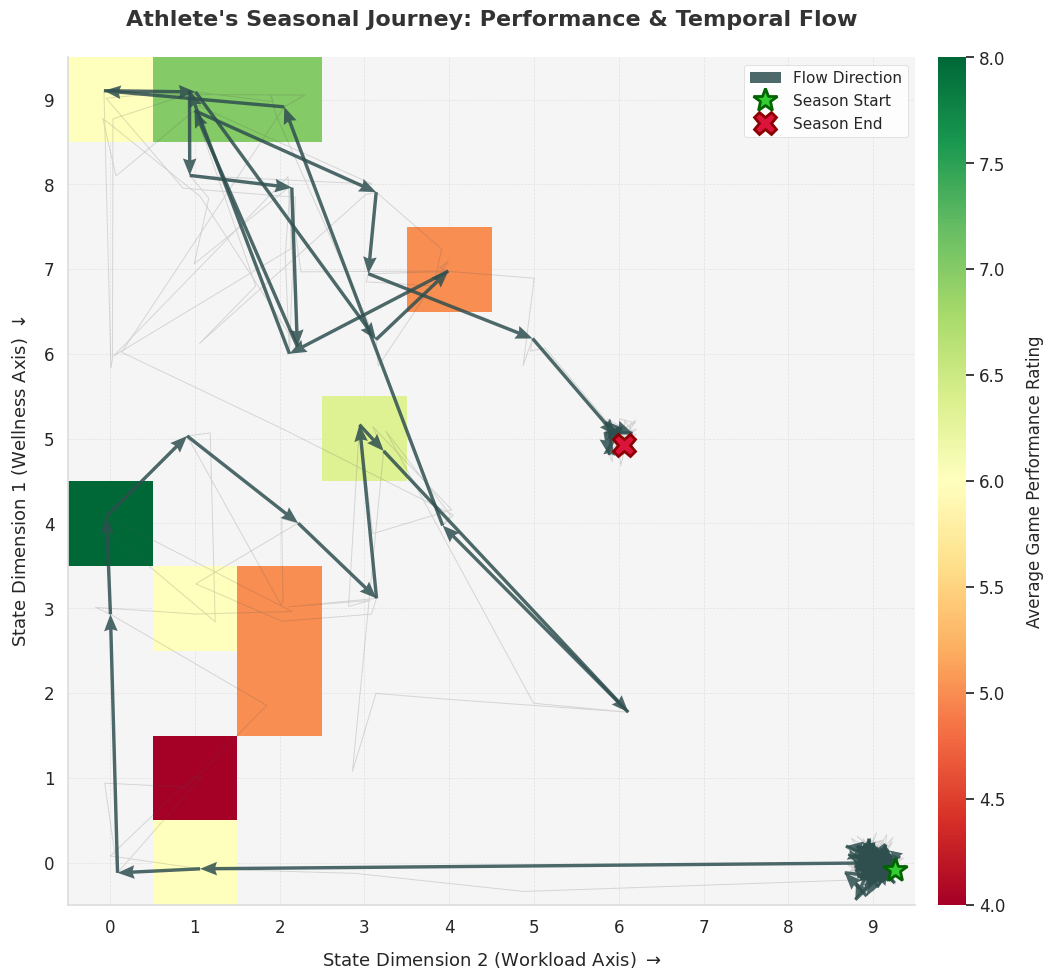

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set a modern, clean aesthetic
sns.set_theme(style="whitegrid", font_scale=1.1, rc={"grid.linewidth": 0.5})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

def plot_performance_benchmarking_aesthetic(som, df_original, trajectory):
    """
    Aesthetically improved visualization of 'Game Performance' and directional flow.
    """
    # 1. Create grids
    perf_map = np.zeros((som.x, som.y))
    count_map = np.zeros((som.x, som.y))
    performances = df_original['team_performance'].values
    
    print("Mapping Performance to States...")
    for i, (x, y) in enumerate(trajectory):
        perf = performances[i]
        if not np.isnan(perf):
            perf_map[int(x), int(y)] += perf
            count_map[int(x), int(y)] += 1
            
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_perf_map = perf_map / count_map
        avg_perf_map[count_map == 0] = np.nan

    # 2. Setup Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_facecolor('whitesmoke') # Soft background
    
    # --- A. Plot the Heatmap ---
    # Use a reversed Red-Yellow-Green map (Green=High, Red=Low)
    current_cmap = plt.cm.RdYlGn_r.reversed() 
    current_cmap.set_bad(color='white', alpha=0.1) 
    
    heatmap = ax.imshow(avg_perf_map, cmap=current_cmap, interpolation='nearest', zorder=1)
    
    # Add a nice colorbar
    cbar = plt.colorbar(heatmap, ax=ax, pad=0.02, aspect=30)
    cbar.set_label('Average Game Performance Rating', fontsize=12, labelpad=15)
    cbar.outline.set_visible(False)

    # --- B. Plot the Trajectory & Flow ---
    jitter_scale = 0.12
    # Swap X and Y for plotting
    y_points = trajectory[:, 0] + np.random.randn(len(trajectory)) * jitter_scale
    x_points = trajectory[:, 1] + np.random.randn(len(trajectory)) * jitter_scale
    
    # 1. Faint Path Line
    ax.plot(x_points, y_points, color='#555555', alpha=0.2, linewidth=0.7, zorder=2)
    
    # 2. Directional Arrows
    step_size = 4 
    u = x_points[step_size::step_size] - x_points[:-step_size:step_size]
    v = y_points[step_size::step_size] - y_points[:-step_size:step_size]
    x_origins = x_points[:-step_size:step_size]
    y_origins = y_points[:-step_size:step_size]

    q = ax.quiver(x_origins, y_origins, u, v, 
               angles='xy', scale_units='xy', scale=1, 
               color='#2F4F4F', alpha=0.85, width=0.004, headwidth=4, 
               headlength=5, headaxislength=4.5, zorder=3, label='Flow Direction')

    # --- C. Markers & Polish ---
    # Start: A nice green star
    ax.plot(x_points[0], y_points[0], marker='*', markersize=18, 
            color='limegreen', markeredgecolor='darkgreen', markeredgewidth=2, 
            zorder=5, label='Season Start', linestyle='None')
    
    # End: A bold red 'X'
    ax.plot(x_points[-1], y_points[-1], marker='X', markersize=16, 
            color='crimson', markeredgecolor='darkred', markeredgewidth=2, 
            zorder=5, label='Season End', linestyle='None')
    
    # Titles and Labels (FIXED: Added 'r' before strings for LaTeX safety)
    ax.set_title("Athlete's Seasonal Journey: Performance & Temporal Flow\n", 
                 fontsize=16, fontweight='bold', color='#333333')
    
    # The 'r' here tells Python to treat backslashes as literal text, not escape characters
    ax.set_xlabel(r"State Dimension 2 (Workload Axis) $\rightarrow$", fontsize=13, labelpad=10)
    ax.set_ylabel(r"State Dimension 1 (Wellness Axis) $\downarrow$", fontsize=13, labelpad=10)
    
    # Legend styling
    legend = ax.legend(loc='upper right', frameon=True, fancybox=True, 
                       framealpha=0.9, edgecolor='lightgrey', fontsize=11)
    legend.get_frame().set_linewidth(0.5)

    # Clean up axes
    ax.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.7, zorder=0)
    ax.set_xticks(np.arange(som.y))
    ax.set_yticks(np.arange(som.x))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.spines['left'].set_color('#DDDDDD')
    
    # Match matrix coordinates
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Run the aesthetic version
plot_performance_benchmarking_aesthetic(som, player_df, trajectory)

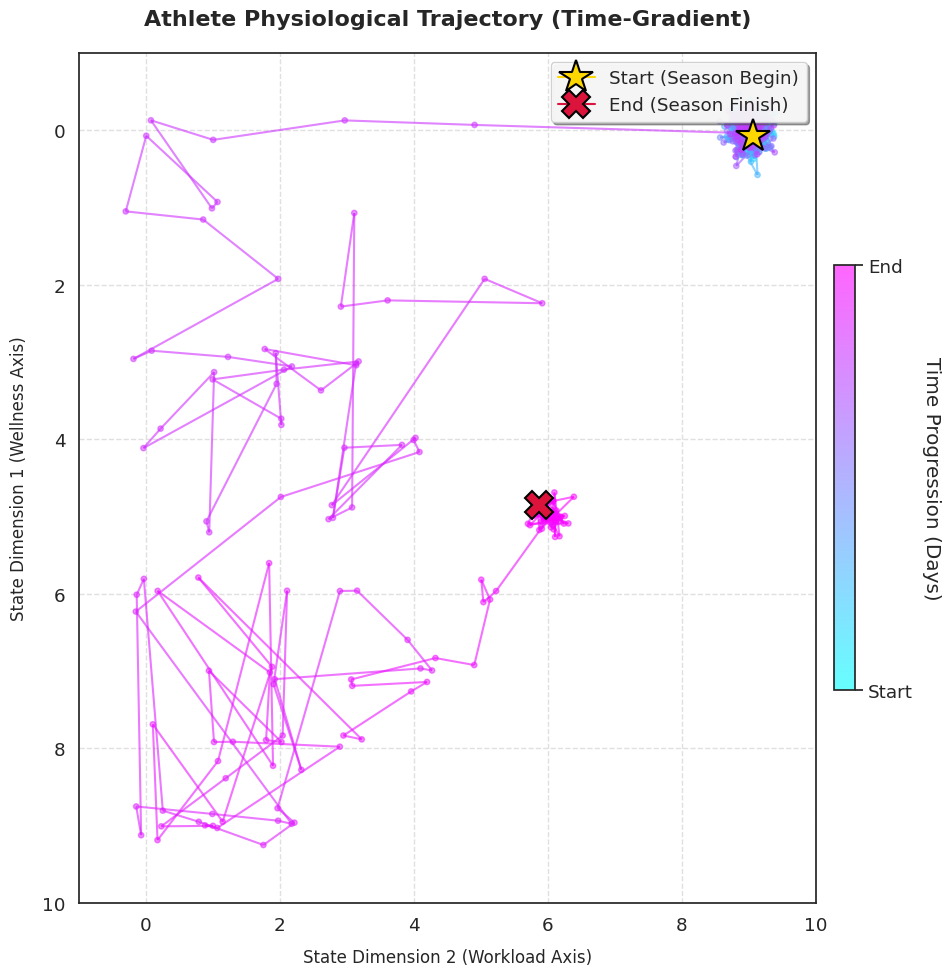

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.collections import LineCollection

# Set global professional style
sns.set_theme(style="white", font_scale=1.2)
plt.rcParams['font.family'] = 'sans-serif'

def plot_aesthetic_trajectory(som, trajectory):
    """
    Plots the trajectory with a Time-Gradient (Color changes from Start to End).
    This allows you to see the 'Flow' without messy arrows.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 1. Add Jitter (Vital for SOMs to see density)
    # We add a fixed random seed so the jitter is the same every time you plot
    np.random.seed(42) 
    jitter_strength = 0.15
    y = trajectory[:, 0] + np.random.randn(len(trajectory)) * jitter_strength
    x = trajectory[:, 1] + np.random.randn(len(trajectory)) * jitter_strength

    # 2. Create the Time-Gradient Line
    # We create segments: (x0, y0) -> (x1, y1)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Normalize time for coloring (0 to 1)
    norm = plt.Normalize(0, len(x))
    
    # Create the LineCollection (Color map: 'cool' goes from Cyan to Purple)
    lc = LineCollection(segments, cmap='cool', norm=norm, alpha=0.6)
    lc.set_array(np.arange(len(x)))
    lc.set_linewidth(1.5)
    
    line = ax.add_collection(lc)
    
    # 3. Add Markers for Every Day (Optional, faint dots to show distinct days)
    ax.scatter(x, y, c=np.arange(len(x)), cmap='cool', s=15, alpha=0.5, zorder=2)

    # 4. Start and End Markers (High contrast)
    # Start: Gold Star with black outline
    ax.plot(x[0], y[0], marker='*', markersize=25, 
            color='#FFD700', markeredgecolor='black', markeredgewidth=1.5, 
            label='Start (Season Begin)', zorder=10)
    
    # End: Crimson X with black outline
    ax.plot(x[-1], y[-1], marker='X', markersize=20, 
            color='#DC143C', markeredgecolor='black', markeredgewidth=1.5, 
            label='End (Season Finish)', zorder=10)

    # 5. Styling
    ax.set_xlim(-1, som.y)
    ax.set_ylim(-1, som.x)
    ax.invert_yaxis() # Match matrix coordinates (0,0 at top left)
    
    # Subtle Grid
    ax.grid(True, color='#E0E0E0', linestyle='--', linewidth=1)
    ax.set_axisbelow(True) # Put grid behind plot elements
    
    # Labels
    ax.set_title("Athlete Physiological Trajectory (Time-Gradient)", fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel("State Dimension 2 (Workload Axis)", fontsize=12, labelpad=10)
    ax.set_ylabel("State Dimension 1 (Wellness Axis)", fontsize=12, labelpad=10)
    
    # Custom Legend
    ax.legend(loc='upper right', frameon=True, framealpha=0.9, fancybox=True, shadow=True)
    
    # Add a Colorbar to explain the Gradient
    cbar = fig.colorbar(line, ax=ax, shrink=0.5, pad=0.02)
    cbar.set_label('Time Progression (Days)', rotation=270, labelpad=20)
    cbar.set_ticks([0, len(x)])
    cbar.set_ticklabels(['Start', 'End'])

    plt.tight_layout()
    plt.show()

# Run it
plot_aesthetic_trajectory(som, trajectory)

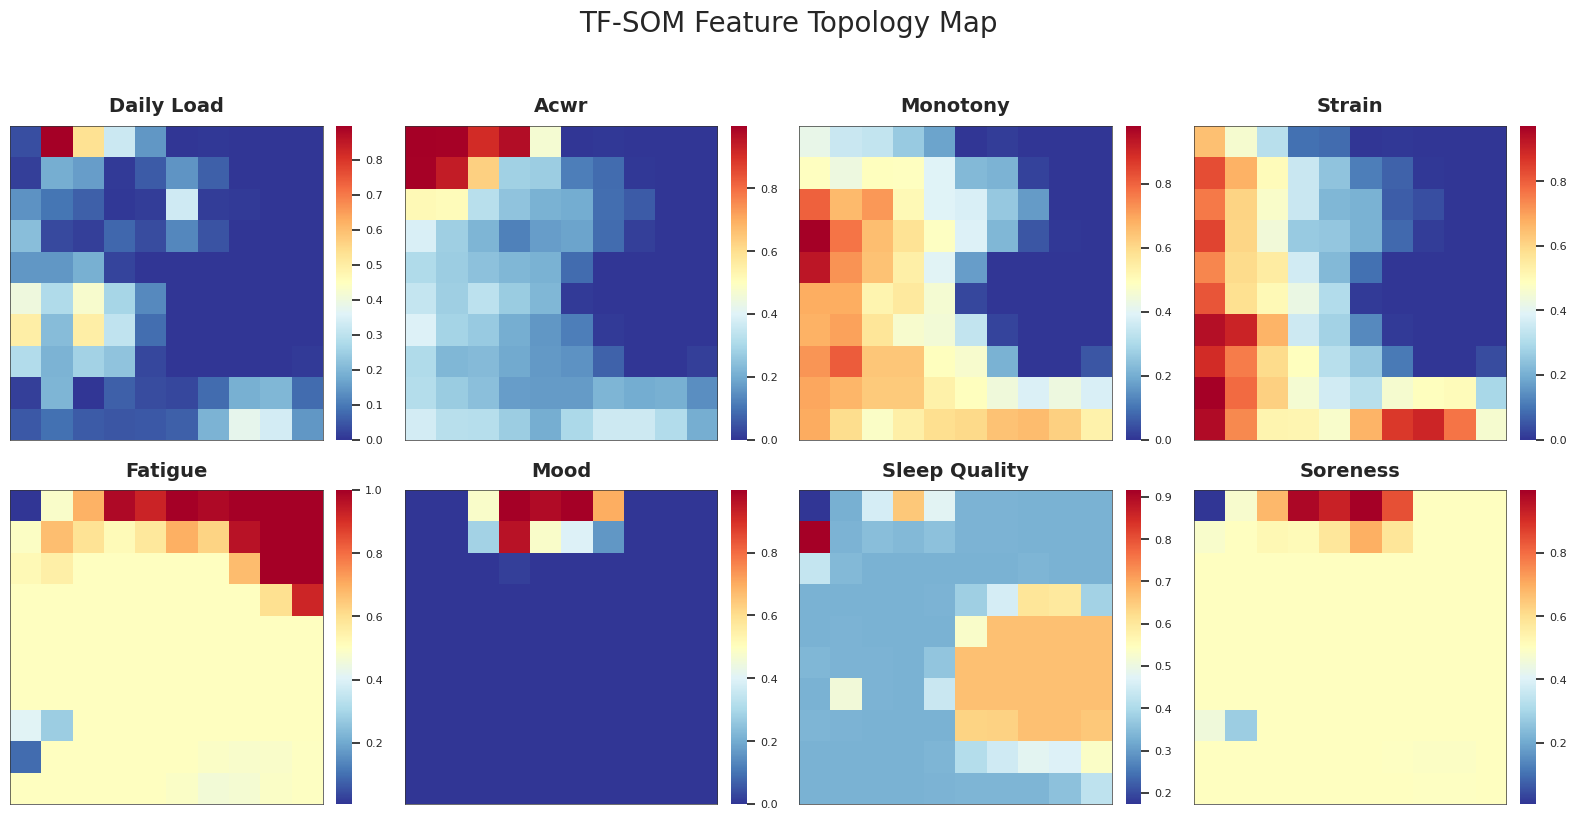

In [46]:
def plot_aesthetic_feature_grid(som, feature_names):
    """
    Plots small multiples of features in a clean, dashboard style.
    """
    n_features = len(feature_names)
    cols = 4  # 4 columns looks wider and cleaner
    rows = (n_features // cols) + (1 if n_features % cols > 0 else 0)
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten()
    
    # Use a diverging colormap (Blue=Low, White=Avg, Red=High)
    cmap = 'RdYlBu_r' 

    for i, name in enumerate(feature_names):
        ax = axes[i]
        
        # Get weights
        weights = som.weights[:, :, i]
        
        # Plot Heatmap
        im = ax.imshow(weights, cmap=cmap, interpolation='nearest', aspect='auto')
        
        # Clean Styling
        ax.set_title(name.replace('_', ' ').title(), fontsize=14, fontweight='bold', pad=10)
        ax.grid(False) # No grid on heatmaps
        
        # Remove ticks (they are abstract dimensions anyway)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add a thin border
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('#333333')
            spine.set_linewidth(0.5)

        # Individual colorbars are messy. 
        # Instead, we just let the colors speak (Red=High, Blue=Low) 
        # or add a tiny internal one. Let's add a tiny one.
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        cbar.outline.set_visible(False)

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.suptitle("TF-SOM Feature Topology Map", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

# Run it
plot_aesthetic_feature_grid(som, features)